<a href="https://colab.research.google.com/github/vpinilla001/DeepAnT/blob/master/ANN_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
%matplotlib inline

In [2]:
df = pd.read_csv("/content/art_daily_nojump.csv")
df.head()

,timestamp,value,label
0,2014-04-01 00:00:00,21.598011,0
1,2014-04-01 00:05:00,19.321392,0
2,2014-04-01 00:10:00,21.399938,0
3,2014-04-01 00:15:00,18.373916,0
4,2014-04-01 00:20:00,18.167499,0


In [3]:
df.drop(['label'], axis=1, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index(['timestamp'], drop=True)
df.head(10)

,value
timestamp,
2014-04-01 00:00:00,21.598011
2014-04-01 00:05:00,19.321392
2014-04-01 00:10:00,21.399938
2014-04-01 00:15:00,18.373916
2014-04-01 00:20:00,18.167499
2014-04-01 00:25:00,20.016181
2014-04-01 00:30:00,18.238649
2014-04-01 00:35:00,19.569959
2014-04-01 00:40:00,21.587112


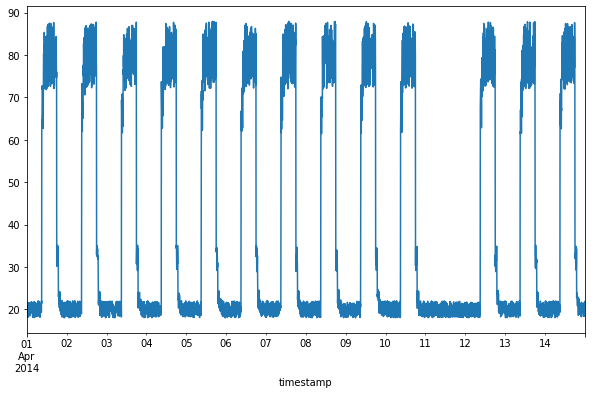

In [4]:
plt.figure(figsize=(10, 6))
df['value'].plot();

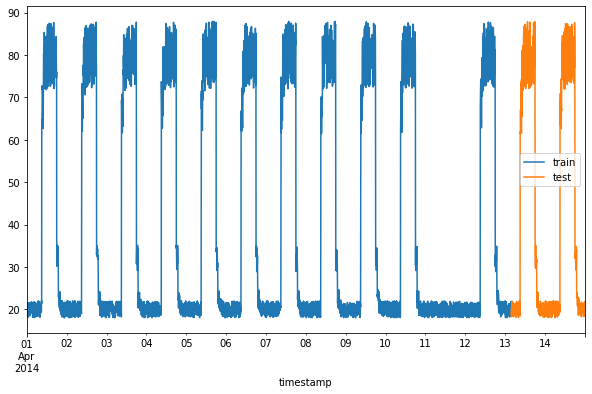

In [5]:
split_date = pd.Timestamp('2014-04-13 03:40:00')
df =  df['value']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [6]:
df = pd.DataFrame(df)

In [7]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = ['value'])
# train_sc = scaler.fit_transform(train.values.reshape(-1,1))
# test_sc = scaler.transform(test.values.reshape(-1,1))

In [8]:
df

,value
0,0.051413
1,0.018877
2,0.048582
3,0.005337
4,0.002387
...,...
4027,0.005419
4028,0.019770
4029,0.048923
4030,0.055031


In [9]:
from sklearn.base import TransformerMixin
class Lags(TransformerMixin):
    def __init__(self, lag=2, dropna=True):
        self.lag = lag
        self.dropna = dropna
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if type(X) is pd.DataFrame:
            new_dict={}
            for col_name in X:
                #new_dict[col_name]=X[col_name]
                # create lagged Series
                for l in range(1,self.lag+1):
                    new_dict['%s_lag%d' %(col_name,l)]=X[col_name].shift(l)
            res=pd.DataFrame(new_dict,index=X.index)

 

        elif type(X) is pd.Series:
            the_range=range(0,self.lag+1)
            res=pd.concat([X.shift(i) for i in the_range],axis=1)
            res.columns=['lag_%d' %i for i in the_range]
        else:
            print('Only works for DataFrame or Series')
            return None
        if self.dropna:
            return res.dropna()
        else:
            return res

In [10]:
df

,value
0,0.051413
1,0.018877
2,0.048582
3,0.005337
4,0.002387
...,...
4027,0.005419
4028,0.019770
4029,0.048923
4030,0.055031


In [11]:
X = Lags(lag = 2).transform(df)

In [12]:
X

,value_lag1,value_lag2
2,0.018877,0.051413
3,0.048582,0.018877
4,0.005337,0.048582
5,0.002387,0.005337
6,0.028807,0.002387
...,...,...
4027,0.008126,0.037530
4028,0.005419,0.008126
4029,0.019770,0.005419
4030,0.048923,0.019770


In [13]:
predict_days = 1
lag0 = df['value'][:-2]
lag1 = X['value_lag1']

# X_test = test_sc[:-predict_days]
# y_test = test_sc[predict_days:]

In [14]:
nn_model = Sequential()
nn_model.add(Dense(2, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 4         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [15]:
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(lag1, lag0, epochs=1, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

4030/4030 [==============================] - 3s 734us/step - loss: 0.0603


In [16]:
y_pred_test_nn = nn_model.predict(lag0)

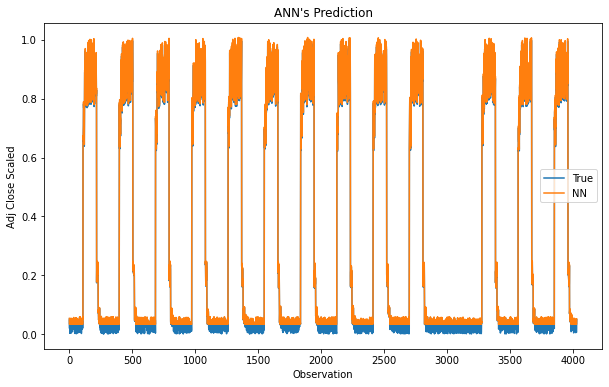

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(lag0, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

Epoch 1/20
2014/2014 - 2s - loss: 0.0516
Epoch 2/20
2014/2014 - 2s - loss: 0.0065
Epoch 3/20
2014/2014 - 2s - loss: 0.0065
Epoch 4/20
2014/2014 - 2s - loss: 0.0065
Epoch 5/20
2014/2014 - 2s - loss: 0.0063
Epoch 6/20
2014/2014 - 2s - loss: 0.0062
Epoch 7/20
2014/2014 - 2s - loss: 0.0062
Epoch 8/20
2014/2014 - 2s - loss: 0.0062
Epoch 9/20
2014/2014 - 2s - loss: 0.0062
Epoch 10/20
2014/2014 - 2s - loss: 0.0061
Epoch 11/20
2014/2014 - 2s - loss: 0.0061
Epoch 12/20
2014/2014 - 2s - loss: 0.0061
Epoch 13/20
2014/2014 - 2s - loss: 0.0061
Epoch 14/20
2014/2014 - 2s - loss: 0.0061
Epoch 15/20
2014/2014 - 2s - loss: 0.0060
Epoch 16/20
2014/2014 - 2s - loss: 0.0060
Epoch 17/20
2014/2014 - 2s - loss: 0.0060
Epoch 18/20
2014/2014 - 2s - loss: 0.0060
Epoch 19/20
2014/2014 - 2s - loss: 0.0060
Epoch 20/20
2014/2014 - 2s - loss: 0.0060
Train Score: 5.36 RMSE
Test Score: 4.92 RMSE


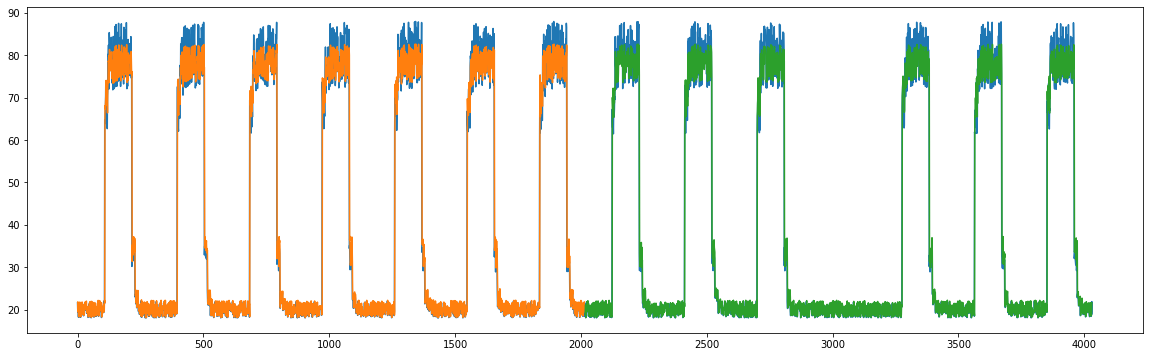

In [21]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('/content/art_daily_nojump.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.50)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Epoch 1/50
156/156 - 0s - loss: 0.0029
Epoch 2/50
156/156 - 0s - loss: 0.0026
Epoch 3/50
156/156 - 0s - loss: 0.0025
Epoch 4/50
156/156 - 0s - loss: 0.0024
Epoch 5/50
156/156 - 0s - loss: 0.0023
Epoch 6/50
156/156 - 0s - loss: 0.0022
Epoch 7/50
156/156 - 0s - loss: 0.0021
Epoch 8/50
156/156 - 0s - loss: 0.0019
Epoch 9/50
156/156 - 0s - loss: 0.0018
Epoch 10/50
156/156 - 0s - loss: 0.0016
Epoch 11/50
156/156 - 0s - loss: 0.0014
Epoch 12/50
156/156 - 0s - loss: 0.0011
Epoch 13/50
156/156 - 0s - loss: 9.3585e-04
Epoch 14/50
156/156 - 0s - loss: 7.6403e-04
Epoch 15/50
156/156 - 0s - loss: 5.7845e-04
Epoch 16/50
156/156 - 0s - loss: 5.0262e-04
Epoch 17/50
156/156 - 0s - loss: 4.3627e-04
Epoch 18/50
156/156 - 0s - loss: 3.0149e-04
Epoch 19/50
156/156 - 0s - loss: 2.7346e-04
Epoch 20/50
156/156 - 0s - loss: 2.8183e-04
Epoch 21/50
156/156 - 0s - loss: 2.2377e-04
Epoch 22/50
156/156 - 0s - loss: 2.0291e-04
Epoch 23/50
156/156 - 0s - loss: 1.4701e-04
Epoch 24/50
156/156 - 0s - loss: 1.6771e-04
E

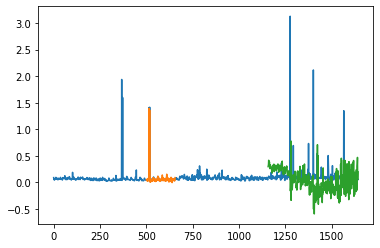

In [34]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('/content/exchange-4_cpc_results.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.40)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 500
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [51]:
df = pd.read_csv("/content/art_daily_nojump.csv")
df.head()

,timestamp,value,label
0,2014-04-01 00:00:00,21.598011,0
1,2014-04-01 00:05:00,19.321392,0
2,2014-04-01 00:10:00,21.399938,0
3,2014-04-01 00:15:00,18.373916,0
4,2014-04-01 00:20:00,18.167499,0


In [52]:
df['value']

0       21.598011
1       19.321392
2       21.399938
3       18.373916
4       18.167499
          ...    
4027    18.379705
4028    19.383839
4029    21.423756
4030    21.851140
4031    18.969085
Name: value, Length: 4032, dtype: float64

In [53]:
df['value'][:-3]

0       21.598011
1       19.321392
2       21.399938
3       18.373916
4       18.167499
          ...    
4024    21.233844
4025    20.626564
4026    18.569065
4027    18.379705
4028    19.383839
Name: value, Length: 4029, dtype: float64

In [54]:
arrays = np.split(df['value'][:-3], 5)

ValueError: ignored

In [55]:
import scipy
from scipy import stats

In [56]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress

In [57]:
stats.friedmanchisquare(arrays[0], arrays[1], arrays[2], arrays[3], arrays[4])

FriedmanchisquareResult(statistic=371.53902439024387, pvalue=3.914100136905453e-79)

In [58]:
df['value'].autocorr(lag=100)

-0.4391946928692329

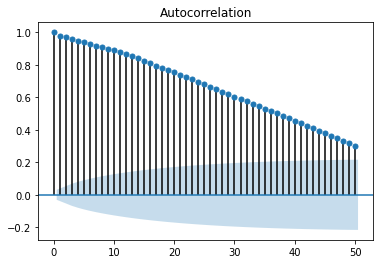

In [60]:
plot_acf(df['value'], lags=50)
plt.show()